In [1]:
import tensorflow as tf
from keras import backend as K
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
K.tensorflow_backend.set_session(sess)

Using TensorFlow backend.


In [3]:
%%time
import os
import cv2
import collections

from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image
import time
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

from coco_preprocessing import *
from expl_train_utils import *
from rectangular_images.fp16util import *
from rectangular_images.resnet import *
from rectangular_images.validation_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
CPU times: user 270 ms, sys: 32.6 ms, total: 303 ms
Wall time: 344 ms


In [4]:
from keras.backend.tensorflow_backend import set_session
from keras_contrib.applications.resnet import ResNet18
from keras.applications import vgg16
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Input
from keras.optimizers import Adam, SGD

### Load Dataset

In [5]:
dataDir=''
dataType='val2017'
annFile='annotations/instances_{}.json'.format(dataType)

In [6]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.77s)
creating index...
index created!


In [7]:
num_cats = 10

In [8]:
# Get categories with largest number of images to use
numCatImgs = []
for i in range(90):
    numCatImgs.append((i, len(coco.getImgIds(catIds=i))))
numCatImgs.sort(key=lambda x: x[1])
usedCatImgs = numCatImgs[-num_cats:] # list of (catId, numImgs) tuples
minNumImgs = usedCatImgs[0][1] # number of images available for smallest used cat(egory)
used_ids = [tup[0] for tup in usedCatImgs] # list of catIds used

used_cats = coco.loadCats(coco.getCatIds(catIds=used_ids))
cat_names = [cat['name'] for cat in used_cats]
print('{} COCO categories used: \n{}\n'.format(len(used_cats), ' '.join(cat_names)))

10 COCO categories used: 
person car truck bench handbag bottle cup bowl chair dining table



In [9]:
print(used_ids)

[15, 8, 31, 51, 44, 47, 67, 3, 62, 1]


In [10]:
catId_to_catName = {d['id']: d['name'] for d in used_cats}

### Load All Images

In [11]:
imgIds = [img_info for used_id in used_ids for img_info in coco.getImgIds(catIds=used_id)]

In [12]:
%%time
# preprocess --> bboxImgs, object_labels, configs, shapelyPolygons
data = [preprocess(coco, img_info, used_ids) for img_info in coco.loadImgs(imgIds)[:100]]
data = np.array(data)
np.random.shuffle(data)

CPU times: user 1.64 s, sys: 111 ms, total: 1.75 s
Wall time: 56.6 s


### Rectangular

In [15]:
import torch
import torchvision

from pathlib import Path

In [16]:
datapath = Path("/data/rliaw/explainability/images")
valdir = "/data/rliaw/explainability/images"

In [34]:
# Sort the images by aspect ratios
idx_ar_sorted = sort_ar(datapath, valdir)

 18%|█▊        | 131/737 [00:00<00:00, 1269.96it/s]

Creating AR indexes. Please be patient this may take a couple minutes...


100%|██████████| 737/737 [00:00<00:00, 1901.85it/s]


In [35]:
# Make sure is sorted
print('First five:', idx_ar_sorted[:5])
print('Last five:', idx_ar_sorted[-5:])

First five: [(517, 0.11382), (512, 0.12651), (450, 0.14286), (649, 0.18182), (283, 0.18681)]
Last five: [(83, 9.3), (3, 10.42857), (92, 11.625), (110, 18.66667), (125, 19.21429)]


In [36]:
# Validation batch size
val_bs = 128
# Mapping from image id to aspect ratio
idx2ar = map_idx2ar(idx_ar_sorted, val_bs)
target_size = 128

In [44]:
# Rect
val_ar_tfms = [transforms.Resize(int(target_size*1.14)), RectangularCropTfm(idx2ar, target_size)]
# val_ar_tfms = [transforms.Resize(target_size), RectangularCropTfm(idx2ar, target_size)]
val_dataset_ar = ValDataset(valdir, val_ar_tfms)

# No transforms
orig_dataset = datasets.ImageFolder(valdir, transforms.Resize(target_size))

val_tfms = [transforms.Resize(int(target_size*1.14)), transforms.CenterCrop(target_size)]
# val_tfms = [transforms.Resize(target_size), transforms.CenterCrop(target_size)]
val_dataset = datasets.ImageFolder(valdir,  transforms.Compose(val_tfms))

min_scale = 0.5
trn_tfms = [
        transforms.RandomResizedCrop(target_size, scale=(min_scale, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]
tta_aug_dataset = datasets.ImageFolder(valdir, transforms.Compose(trn_tfms))

In [45]:
print(tta_aug_dataset)

Dataset ImageFolder
    Number of datapoints: 737
    Root Location: /data/rliaw/explainability/images
    Transforms (if any): Compose(
                             RandomResizedCrop(size=(128, 128), scale=(0.5, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                             RandomHorizontalFlip(p=0.5)
                             ToTensor()
                         )
    Target Transforms (if any): None


In [46]:
print(tta_aug_dataset[20])

(tensor([[[0.3804, 0.3804, 0.3804,  ..., 0.0784, 0.0784, 0.0784],
         [0.3804, 0.3804, 0.3804,  ..., 0.0784, 0.0784, 0.0784],
         [0.3804, 0.3804, 0.3804,  ..., 0.0784, 0.0784, 0.0784],
         ...,
         [0.8392, 0.8392, 0.8392,  ..., 0.8275, 0.8275, 0.8275],
         [0.8392, 0.8392, 0.8392,  ..., 0.8275, 0.8275, 0.8275],
         [0.8392, 0.8392, 0.8392,  ..., 0.8275, 0.8275, 0.8275]],

        [[0.3216, 0.3216, 0.3216,  ..., 0.1294, 0.1294, 0.1294],
         [0.3216, 0.3216, 0.3216,  ..., 0.1294, 0.1294, 0.1294],
         [0.3216, 0.3216, 0.3216,  ..., 0.1294, 0.1294, 0.1294],
         ...,
         [0.7255, 0.7255, 0.7255,  ..., 0.5490, 0.5490, 0.5490],
         [0.7255, 0.7255, 0.7255,  ..., 0.5490, 0.5490, 0.5490],
         [0.7255, 0.7255, 0.7255,  ..., 0.5490, 0.5490, 0.5490]],

        [[0.4118, 0.4118, 0.4118,  ..., 0.1020, 0.1020, 0.1020],
         [0.4118, 0.4118, 0.4118,  ..., 0.1020, 0.1020, 0.1020],
         [0.4118, 0.4118, 0.4118,  ..., 0.1020, 0.1020, 0

In [47]:
def show_validation_image(sorted_index, figsize=(10,10)):
    index, aspect_ratio = idx_ar_sorted[sorted_index]
    print('Aspect ratio:', aspect_ratio)
    f, (ax1, ax2, ax3) = plt.subplots(3, 2, figsize=figsize)
    f.tight_layout(h_pad=6.0)
    fontsize = 15
    ax1[0].imshow(orig_dataset[index][0])
    ax1[0].set_title('Center Crop Image', fontsize=fontsize)
    ax1[1].imshow(val_dataset_ar[index][0])
    ax1[1].set_title('FastAi Rectangular Crop', fontsize=fontsize)
    ax2[0].imshow(val_dataset[index][0])
    ax2[0].set_title('Imagenet Center Crop', fontsize=fontsize)
    ax2[1].imshow(tta_aug_dataset[index][0])
    ax2[1].set_title('Test Time Augmentation 1', fontsize=fontsize)
    ax3[0].imshow(tta_aug_dataset[index][0])
    ax3[0].set_title('Test Time Augmentation 2', fontsize=fontsize)
    ax3[1].imshow(tta_aug_dataset[index][0])
    ax3[1].set_title('Test Time Augmentation 3', fontsize=fontsize)

In [48]:
print(isinstance(orig_dataset, torch.utils.data.Dataset))

True


In [49]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
#             for inputs, labels in dataloaders[phase]:
#             dataloaders = {'train': torch.utils.data.DataLoader(orig_dataset),
#                            'val': torch.utils.data.DataLoader(orig_dataset)}
            for inputs, labels in torch.utils.data.DataLoader(tta_aug_dataset):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [50]:
model_ft = resnet18(num_classes=10)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

device = torch.device("cuda")
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

import copy
from torch import optim
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


RuntimeError: CuDNN error: CUDNN_STATUS_EXECUTION_FAILED

### Using Keras VGG16 Model

In [18]:
# input_tensor = Input(shape=(96, 96, 3))
# inet_model = vgg16.VGG16(input_tensor=input_tensor, weights=None, include_top=False)
inet_model = ResNet18((96, 96, 3), 10)
model = inet_model

reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...


In [19]:
num_samples = 100
batch_size = 10
num_classes = 10
num_batches = num_samples // batch_size
iteration = 0

base_model = inet_model
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(1024, activation='relu')(x)
# predictions = Dense(num_classes, activation='softmax')(x)
# model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy',
              metrics=['acc'])

In [20]:
x_train = data[:, 0] # Bbox images

orig_x_train = []
temp = []
for bbox_imgs in x_train:
    for img in bbox_imgs:
        if len(img.shape) != 3:
            img = np.stack((img,) * 3, -1)
        orig_x_train.append(img)
        alt_img = cv2.resize(img, dsize=(96, 96), interpolation=cv2.INTER_CUBIC)
        temp.append(alt_img)

x_train = np.array(temp)

In [21]:
print(x_train.shape)
print(len(orig_x_train))

(737, 96, 96, 3)
737


In [22]:
image_id = 50

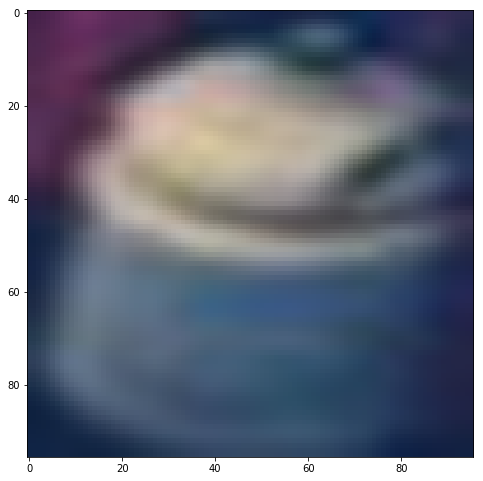

In [25]:
img = x_train[image_id]
plt.imshow(img)

In [26]:
altimg = alt_img.copy()
show_gt_mask(*configs[image_id])

NameError: name 'configs' is not defined

In [27]:
y_train = data[:, 1]
y_train = np.array([label[0] for labels in y_train for label in labels])

temp = np.zeros((y_train.shape[0], num_cats))
for ft in used_ids:
    vec = np.zeros(num_cats)
    vec[used_ids.index(ft)] = 1
    temp[np.where(y_train == ft)] = vec

y_train = temp

In [28]:
print(y_train.shape)

(737, 10)


In [29]:
print(y_train[0])

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [30]:
configs = np.array([config for configs in data[:, 2] for config in configs])

In [31]:
shapely_polygons = np.array([polygon for polygons in data[:, 3] for polygon in polygons])

##### Creating ImageFolder File Structure

In [32]:
from PIL import Image

In [33]:
"""
assert len(orig_x_train) == len(y_train)
for i in range(len(orig_x_train)):
    bbox_im = orig_x_train[i]
    class_dir = np.argmax(y_train[i])
    save_dir = "images/{}".format(class_dir)
    im = Image.fromarray(bbox_im)
    im.save("{}/{}.jpeg".format(save_dir, i))
"""

#### Training Model

In [19]:
# Single Image Inference Time
times = []
for i in range(100):
    s = time.time()
    preds = model.predict(x_train[i][np.newaxis,])
    times.append(time.time() - s)
print("Single Image Inference Time: {} seconds".format(sum(times) / len(times)))

Single Image Inference Time: 0.05168129205703735 seconds


In [ ]:
%%time
"""
# Model training benchmarks
num_epochs = 10
stats = {} # epoch num -> [loss, accuracy, time]

for i in range(1, num_epochs + 1):
    s = time.time()
    model.fit(x_train, y_train,
              epochs=1,
              batch_size=128,
              shuffle=False,
              validation_split=0.1,
              verbose=2)
    t = time.time() - s
    
    model.save_weights('saved_weights/{}.hdf5'.format(i))
    
    stats[i] = model.evaluate(x_train, y_train, batch_size=128, verbose=0) + [t]
"""

In [38]:
%%time
"""
# Model training benchmarks
num_epochs = 10
stats = {} # epoch num -> [loss, accuracy, time]

for i in range(1, num_epochs + 1):
    s = time.time()
    model.fit(x_train, y_train,
              epochs=1,
              batch_size=128,
              shuffle=False,
              validation_split=0.1,
              verbose=2)
    t = time.time() - s
    
    model.save_weights('saved_weights/{}.hdf5'.format(i))
    
    stats[i] = model.evaluate(x_train, y_train, batch_size=128, verbose=0) + [t]
"""

Train on 40344 samples, validate on 4483 samples
Epoch 1/1
 - 103s - loss: 1.9238 - acc: 0.5312 - val_loss: 2.2037 - val_acc: 0.5271
Train on 40344 samples, validate on 4483 samples
Epoch 1/1
 - 98s - loss: 1.3266 - acc: 0.6664 - val_loss: 1.4344 - val_acc: 0.6567
Train on 40344 samples, validate on 4483 samples
Epoch 1/1
 - 98s - loss: 0.9470 - acc: 0.7925 - val_loss: 1.1724 - val_acc: 0.7504
Train on 40344 samples, validate on 4483 samples
Epoch 1/1
 - 98s - loss: 0.7084 - acc: 0.8740 - val_loss: 1.3161 - val_acc: 0.7399
Train on 40344 samples, validate on 4483 samples
Epoch 1/1
 - 98s - loss: 0.5949 - acc: 0.9122 - val_loss: 1.1162 - val_acc: 0.8055
Train on 40344 samples, validate on 4483 samples
Epoch 1/1
 - 98s - loss: 0.5397 - acc: 0.9325 - val_loss: 1.0375 - val_acc: 0.8213
Train on 40344 samples, validate on 4483 samples
Epoch 1/1
 - 98s - loss: 0.5092 - acc: 0.9432 - val_loss: 0.8994 - val_acc: 0.8601
Train on 40344 samples, validate on 4483 samples
Epoch 1/1
 - 98s - loss: 0

In [44]:
model.load_weights('saved_weights/15.hdf5')

Epsilon-Greedy Sampling Time: 9.441375732421875e-05 seconds
Perturbed Data Classification Time: 0.013626575469970703 seconds
data_labels Time: 0.02488231658935547 seconds
Average Epsilon-Greedy Image Creation Time: 0.0005325651168823242 seconds
Average Perturbed Data Point Creation Time: 4.291534423828125e-06 seconds
Average Epsilon-Greedy 10 Image Classification Time: 0.007901906967163086 seconds
Average Reward, Count, and Q-Value Eval Time: 0.00012242794036865234 seconds
Feature Selection Time: 2.574920654296875e-05 seconds
Ridge Regression Time: 0.0020492076873779297 seconds
Prediction Time: 0.0006265640258789062 seconds
Epsilon-Greedy Sampling Time: 0.00010943412780761719 seconds
Perturbed Data Classification Time: 0.010639190673828125 seconds
data_labels Time: 0.021869182586669922 seconds
Average Epsilon-Greedy Image Creation Time: 0.0006131601333618165 seconds
Average Perturbed Data Point Creation Time: 4.455447196960449e-06 seconds
Average Epsilon-Greedy 10 Image Classification 

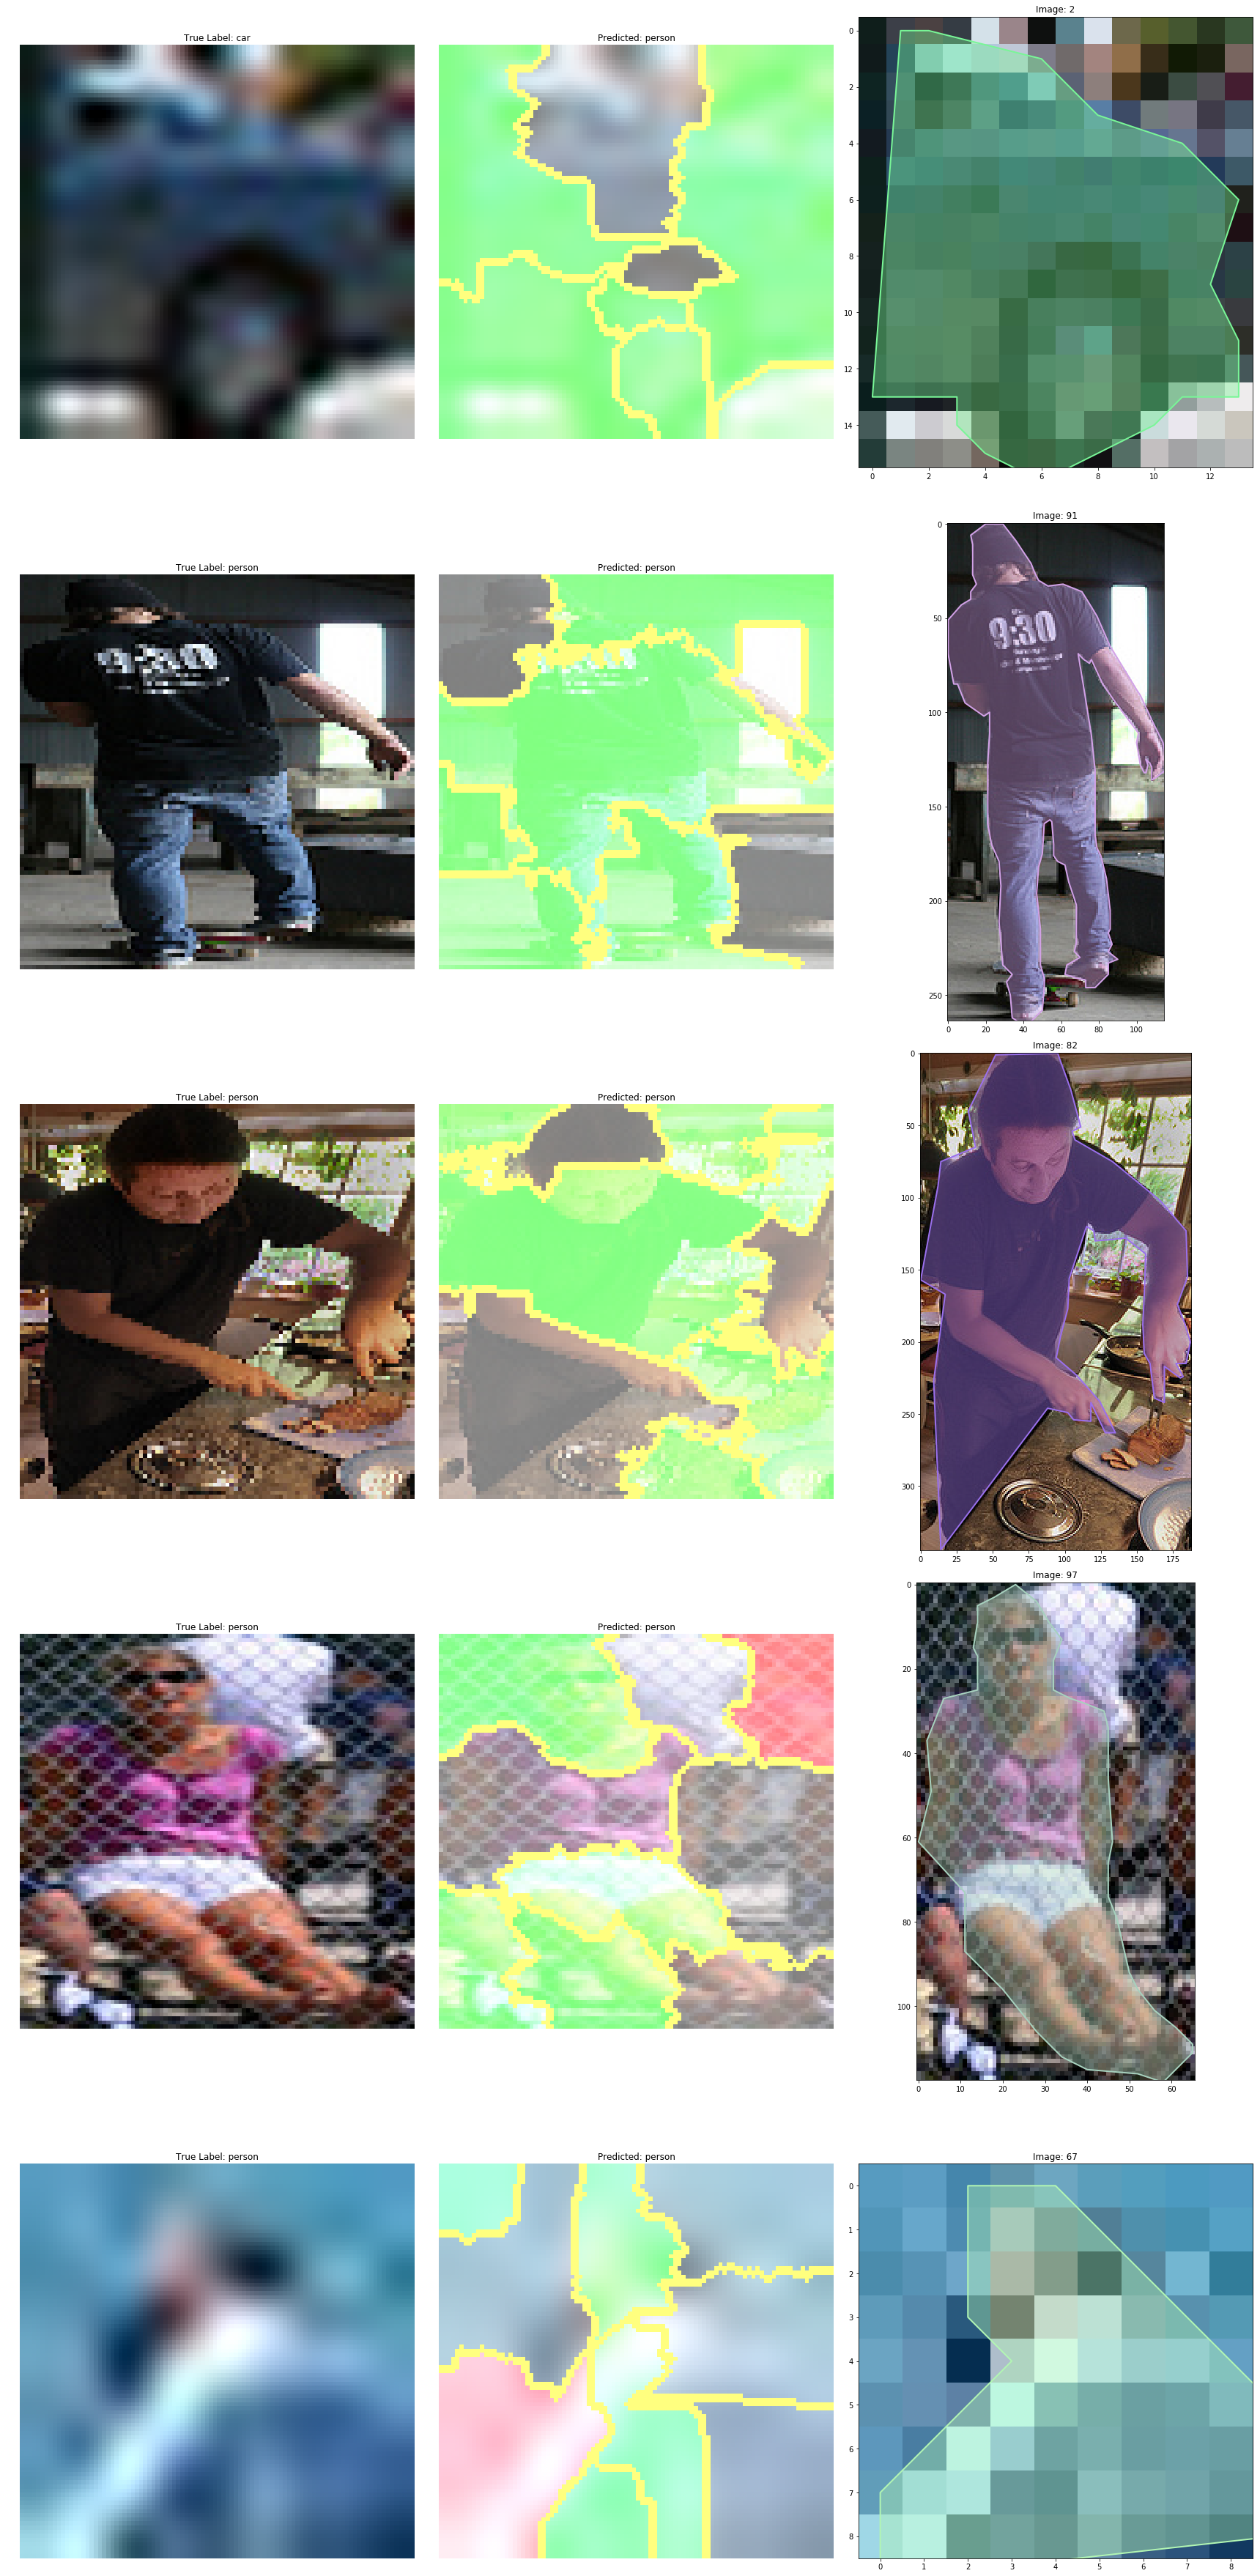

Ran for 5.888 seconds!! (0.098 minutes)
CPU times: user 6.81 s, sys: 2.98 s, total: 9.8 s
Wall time: 5.89 s


In [45]:
%%time
# Using Epsilon-Greedy
start_iter = 0
num_training_samples = 100
num_iterations = 1
samples_per_iter = num_training_samples // num_iterations
explainer_batch_size = 128
batch_size = 128
sp = SubPlotter(num_iterations, use_bandits=True)

for iteration in range(start_iter, start_iter + num_iterations):
    start = iteration * samples_per_iter
    end = (iteration + 1) * samples_per_iter
    
    x_train_batch = x_train[start:end]
    y_train_batch = y_train[start:end]
    configs_batch = configs[start:end]
    shapely_polygons_batch = shapely_polygons[start:end]
    
#     model.fit(x_train_batch, y_train_batch,
#               epochs=1,
#               batch_size=batch_size,
#               shuffle=False,
#               validation_data=(x_train[-100:], y_train[-100:]))
    
#     info = sp.analyzeIoU(model, x_train_batch, y_train_batch, shapely_polygons_batch, limit=20)
#     sp.plot_seg_extremes(info, configs_batch)
    sp.plot_rand_segs(model, used_ids, catId_to_catName, 
                      x_train_batch, y_train_batch, shapely_polygons_batch, configs_batch, num_segs=5)

    print("loss, accuracy = {}\n".format(model.evaluate(x_train, y_train, batch_size=128, verbose=0)))

sp.end()

In [29]:
image_id = 10

In [37]:
img = x_train_batch[image_id]

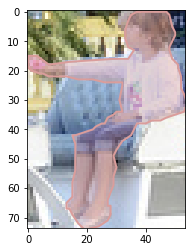

In [30]:
show_gt_mask(*configs[image_id])

In [50]:
bbox_img, polygons, colors = configs_batch[image_id]
polygon_shape = shapely_polygons_batch[image_id]

from skimage.draw import polygon
r, c = polygon(*np.array(polygon_shape.exterior).T)

In [51]:
sPgon = shapely_polygons[i]
arr = [sPgon.contains(Point(r[index], c[index])) for index in range(len(r))]

### Load Single Image (either run this or the `Load All Images` section)

In [7]:
imgIds = [img_info for used_id in used_ids for img_info in coco.getImgIds(catIds=used_id)]
# img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])
img = coco.loadImgs(70229)[0]

In [8]:
print(img)

{'license': 1, 'file_name': '000000070229.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000070229.jpg', 'height': 640, 'width': 481, 'date_captured': '2013-11-24 02:18:11', 'flickr_url': 'http://farm8.staticflickr.com/7174/6397141265_aa0f0d8a4e_z.jpg', 'id': 70229}


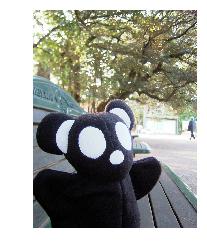

In [9]:
I = imread(img['coco_url'])
plt.axis('off')
plt.imshow(I)
plt.show()

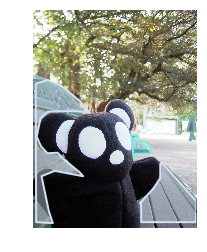

In [10]:
# load and display instance annotations
plt.imshow(I)
plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=used_ids, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

In [11]:
bboxImgs, object_labels, configs, shapelyPolygons = preprocess(coco, img, used_ids)

In [12]:
print(len(configs))

3


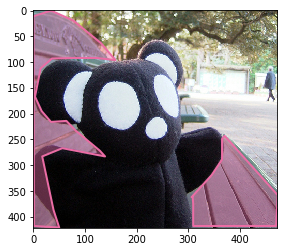

In [13]:
show_gt_mask(*configs[1])

p = Pgon(pairwise_group(alt_segs[0][0]))  
p.contains(Point(20, 60))